In [1]:
# Check RAM Memory

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  
print(ram_gb)

# Login into drive

from google.colab import drive
drive.mount('/content/drive')

# Importing "load_model"

from keras.models import load_model

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
89.63678208
Mounted at /content/drive


In [2]:
import numpy as np

# Download and import data preprocessing .py file
!wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
from data_processing import data_bundle as data_bundle

# Download and import performance metrics .py file
!wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/performance_metrics.py
from performance_metrics import plot_ROC, plot_cm, plot_acc_loss
from sklearn.metrics import classification_report

# Download and import RN50 .py file
! wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/ResNet50.py
from ResNet50 import rn50_seei as rn50_class

# Download and import RN50 .py file

--2023-05-15 03:51:43--  https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3860 (3.8K) [text/plain]
Saving to: ‘data_processing.py’

data_processing.py  100%[===================>]   3.77K  --.-KB/s    in 0s      

2023-05-15 03:51:43 (95.3 MB/s) - ‘data_processing.py’ saved [3860/3860]

--2023-05-15 03:51:44--  https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/performance_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

In [3]:
# Define relevant paths for appropriately instantiating the data_bundle class
images_path_0 = "/content/drive/MyDrive/Thesis/imageset_500_500.npy"
popn_path_0 = "/content/drive/MyDrive/Thesis/siei_processed_v1.csv"
target_var = "hdi"

# In this case GDP has been chose
if target_var == "gdp":
  labels_path_0 = "/content/drive/MyDrive/Thesis/target_logGDP.npy"
  label_type = "GDPpercap"

elif target_var == "hdi":
  labels_path_0 = "/content/drive/MyDrive/Thesis/target_HDI.npy"
  label_type = "HDI"

# Instantiate data_bundle object
basic_bundle = data_bundle(images_path_0, popn_path_0, labels_path_0, label_type)

# Preprocess data through the data_bundle class' methods
basic_bundle.normalize_images()
basic_bundle.normalize_popn()
basic_bundle.bundle_inputs()
basic_bundle.split_data(0.4,0.5,2023)
basic_bundle.unbundle_and_shape_inputs()
basic_bundle.onehot_encode_labels()

# The resulting input sets are: self.X_tri, self.X_vai, self.X_tei (Images) and self.X_trp, self.X_vap, self.X_tep (Population)
# The resulting tragets are: self.y_train_onehot, self.y_val_onehot and self.y_test_onehot
# Where "self" is to be substituted by the given name to the data_bundle instance

/content/data_processing.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(list(zip(self.images, np.array(self.popn))))


### Model: VGG16 - GDP per capita

In [4]:
# Eliminar learning rate de vgg.py y pasar el dropout a argumento de método y no de clase
rn_model = rn50_class(input_shape=(500, 500, 3))

rn_model.load_and_freeze_rn50()
rn_model.enable_dual_input()
rn_model.add_dense_layers(dropout_rate=0.25)
rn_model.define_and_compile_model()
rn_model.fit_model(train_in=[basic_bundle.X_tri, basic_bundle.X_trp], train_tar=basic_bundle.y_train_onehot, 
                    validation_in=[basic_bundle.X_vai, basic_bundle.X_vap], validation_tar=basic_bundle.y_val_onehot, 
                    batch_size=32, epochs=100, es_patience=25)

# Note: if model is on single mode train_in and validation_in should have just one "input" instead of a list of two "inputs"

rn_model.predict([basic_bundle.X_tei, basic_bundle.X_tep])

# model Save/Load  

example_save_path = "/content/drive/MyDrive/Thesis/vgg16_v0.h5"
example_load_path = "/content/drive/MyDrive/Thesis/vgg16_v0.h5"

#vgg_model.save(<path_here>)
#vgg_model.load(<path_here>)

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/100
97/97 [==============================] - 31s 179ms/step - loss: 31.3393 - accuracy: 0.3229 - val_loss: 16.7159 - val_accuracy: 0.4337
Epoch 2/100
97/97 [==============================] - 10s 106ms/step - loss: 15.9670 - accuracy: 0.3772 - val_loss: 21.9561 - val_accuracy: 0.3207
Epoch 3/100
97/97 [==============================] - 10s 106ms/step - loss: 11.0558 - accuracy: 0.3912 - val_loss: 15.7987 - val_accuracy: 0.3879
Epoch 4/100
97/97 [==============================] - 11s 110ms/step - loss: 9.0874 - accuracy: 0.3974 - val_loss: 17.0835 - val_accuracy: 0.4493
Epoch 5/100
97/97 [==============================] - 11s 111ms/step - loss: 6.1057 - accuracy: 0.4459 - val_loss: 10.0920 - val_accuracy: 0.4708
Epoch 6/100
97/97 [==============================] - 11s 111ms/step - loss: 6.6463 - accuracy: 0.4052 - val_loss: 4.7318 - val_accuracy: 0.4795
Epoch 7/100
97/97 [==============================] - 10s 107ms/

In [5]:
rn_model.predict([basic_bundle.X_tei, basic_bundle.X_tep])

33/33 [==============================] - 2s 73ms/step


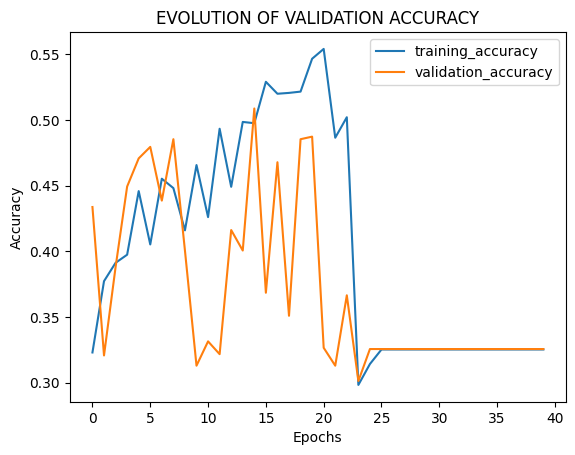

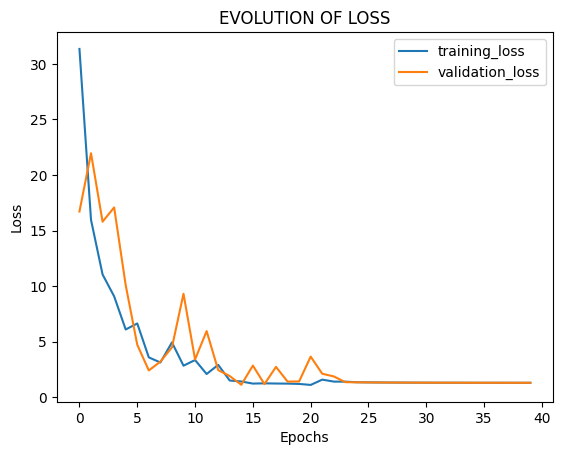

In [6]:
# Val acc. and Val loss evolution
plot_acc_loss(rn_model.fit)

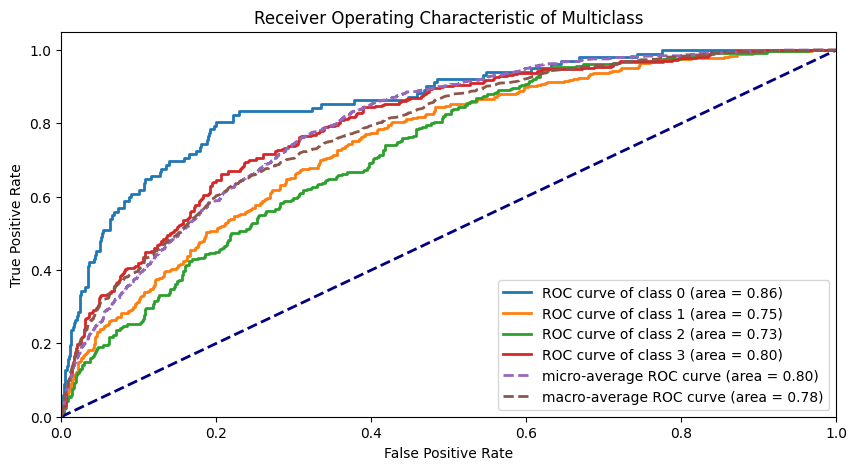

In [7]:
# ROC curves
plot_ROC(rn_model.predictions,basic_bundle.y_test_onehot,4)

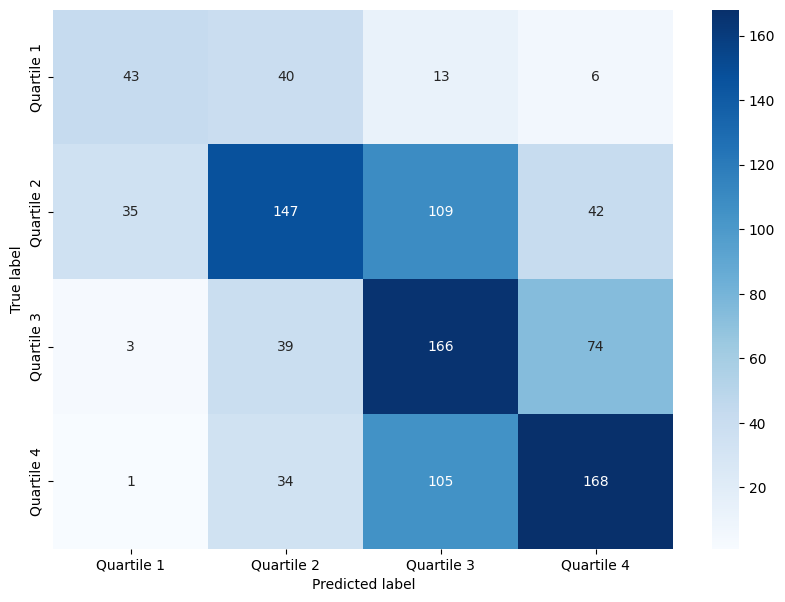

In [8]:
# Confusion matrix
plot_cm(basic_bundle.y_test_onehot,rn_model.predictions)

In [9]:
# Clasification report
print(classification_report(np.argmax(basic_bundle.y_test_onehot, axis=1), np.argmax(rn_model.predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.52      0.42      0.47       102
           1       0.57      0.44      0.50       333
           2       0.42      0.59      0.49       282
           3       0.58      0.55      0.56       308

    accuracy                           0.51      1025
   macro avg       0.52      0.50      0.50      1025
weighted avg       0.53      0.51      0.51      1025

